In [117]:
import piplite
await piplite.install('seaborn')

In [483]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

# Project 2 - Joke Recommendation System

## Jester Joke Data
2.5 million anonymous ratings of jokes by users of the Jester Joke Recommender System (Ken Goldberg, AUTOLab, UC Berkeley).  Values from (-10.00 to +10.00) of 100 jokes collected between April 1999 - May 2003.  Data from 24,983 users who have rated 36 or more jokes, a matrix with dimensions 24983 X 101.

## Jester Joke Recommendation
1. User-based collaborative filtering (UBCF) predicts ratings by aggregating the
ratings of users who have a similar rating history to the active user, we will use this to predict ratings of jokes a user hasn't rated yet.

2. Item-based collaborative filtering (IBCF) uses item-to-item similarity based on
user ratings to find items that are similar to the items the active user likes, we will use this to find similar jokes to ones that a user likes.

In [119]:
original_df = pd.read_csv('jester-data-1.csv')

In [120]:
original_df

,User,Number of Jokes Rated,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,1,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,2,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,3,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,4,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,5,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,24979,100.0,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,24980,91.0,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,24981,39.0,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,24982,37.0,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
#I was curious about the average highest and lowest rated jokes.
average_joke_rating = original_df.mean()
average_joke_rating.sort_values()

58                          -3.829488
16                          -3.102162
44                          -2.110361
57                          -1.988866
13                          -1.761653
                             ...     
36                           3.305442
89                           3.567784
50                           3.659654
Number of Jokes Rated       72.381174
User                     12492.000000
Length: 102, dtype: float64

#### Highest Average Rated Joke 50 (3.659654):
'A guy goes into confession and says to the priest, "Father, I'm 80 years old, widower, with 11 grandchildren. Last night I met two beautiful flight attendants. They took me home and I made love to both of them. Twice."
The priest said: "Well, my son, when was the last time you were in confession?"
"Never Father, I'm Jewish."
"So then, why are you telling me?"
"I'm telling everybody."'

#### Lowest Average Rated Joke 58 (-3.829488):
How many teddybears does it take to change a lightbulb?
It takes only one teddybear, but it takes a whole lot of lightbulbs.

## Part 1:  User-User Collaborative Filtering

User-based collaborative filtering (UBCF) predicts ratings by aggregating the ratings of users who have a similar rating history to the active user, we will use this to predict ratings of jokes a user hasn't rated yet.

## Dense Submatrix
The sub-matrix including only columns {5, 7, 8, 13, 15, 16, 17, 18, 19, 20} is dense. Almost all users have rated those jokes. We can use this subset of the data with no sparsness issues to find users that are most similar to each other with cosine similarity which doesn't work with the NANs in the rest of the dataset.

In [123]:
dense = original_df[["5","7","8","13","15","16","17","18","19","20"]]
dense = pd.DataFrame(dense.fillna(0))
dense

,5,7,8,13,15,16,17,18,19,20
0,-7.52,-9.85,4.17,-7.18,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85
1,-2.38,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,-1.21
2,9.03,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,9.03
3,1.80,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,-2.09
4,1.36,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,4.51
...,...,...,...,...,...,...,...,...,...,...
24978,3.20,-8.79,-0.53,-7.14,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46
24979,0.87,-3.50,5.78,-7.48,-1.75,6.60,3.54,1.50,7.67,-0.44
24980,-7.77,6.70,-6.75,-6.46,-6.80,-6.41,-6.00,7.23,6.75,-6.00
24981,-9.71,4.56,-8.30,-9.47,3.45,-0.92,-4.51,-4.13,-5.73,-9.51


We split the data into test and train not be able to test the model's performance after it has been trained, but also because the full 25k users was too large for the cosine similarity

In [124]:
train_data, test_data = train_test_split(dense, test_size=0.2, random_state=30)

In [125]:
df = pd.melt(original_df.drop(columns=['Number of Jokes Rated']), id_vars=['User'])
df = pd.DataFrame(df)
df = df.rename(columns={"User": "user_id", "variable": "item_id", "value":"rating"})
df

,user_id,item_id,rating
0,1,1,-7.82
1,2,1,4.08
2,3,1,NaN
3,4,1,NaN
4,5,1,8.50
...,...,...,...
2498295,24979,100,7.43
2498296,24980,100,8.45
2498297,24981,100,NaN
2498298,24982,100,NaN


In [126]:
test_data

,5,7,8,13,15,16,17,18,19,20
20323,-7.28,1.31,1.84,-4.56,-4.51,-1.60,-4.90,-4.08,-7.91,-2.18
13070,-1.17,-4.76,-3.30,-6.46,-5.49,-5.19,-7.14,-3.01,-2.57,-2.96
9541,6.21,2.57,-9.32,-9.13,-9.03,-5.34,-1.17,0.00,-9.51,-0.58
17507,4.17,-0.49,-7.77,-5.44,-8.98,-0.29,-5.15,1.46,0.63,4.22
12453,-0.63,3.83,3.69,-1.17,-5.29,-5.29,2.14,0.97,5.68,8.20
...,...,...,...,...,...,...,...,...,...,...
21183,-3.20,-0.44,4.61,-0.29,1.02,4.17,-4.90,5.44,0.78,3.35
3292,-0.34,-5.49,-3.98,-0.44,5.15,-6.21,-7.43,1.50,2.48,-7.62
11461,0.10,0.39,-3.25,2.04,-6.02,-4.03,2.33,-0.29,-1.26,-4.27
20883,-2.91,0.73,2.28,-3.74,-2.62,5.29,-7.28,8.74,-8.25,-8.40


### Normalizing
An important operation for rating matrices is to normalize the entries to, e.g., centering to remove rating bias by subtracting the row mean from all ratings in the row. Normalization is used to remove
individual rating bias by users who consistently always use lower or higher ratings than other users.

In [363]:
normalized_test_data = test_data.sub(test_data.mean(axis=1), axis=0)

### Cosine Similairty:
The cosine of an angle is a function that decreases from 1 to -1 as the angle increases from 0 to 180. You can use the cosine of the angle to find the similarity between two users. The higher the angle, the lower will be the cosine and thus, the lower will be the similarity of the users. You can also inverse the value of the cosine of the angle to get the cosine distance between the users by subtracting it from 1.

In [364]:
user_similarity = cosine_similarity(normalized_test_data)
user_similarity_df = pd.DataFrame(user_similarity)

#reset the index's back to the tes data user_ids rather than 0-4996 that cosine defaults to
user_similarity_df.index = test_data.index
user_similarity_df.columns = test_data.index

user_similarity_df

,20323,13070,9541,17507,12453,16257,10646,3928,1613,11631,...,17133,734,22966,4044,7022,21183,3292,11461,20883,11427
20323,1.000000,-0.174014,-0.032529,-0.245401,0.138158,-0.078647,0.270267,0.456220,-0.293020,-0.510260,...,0.266096,0.368027,-0.765907,0.084974,-0.243858,0.454403,-0.544786,-0.255114,0.444006,-0.160591
13070,-0.174014,1.000000,0.345352,0.654343,0.375232,0.464011,0.007803,-0.232312,0.014889,0.073767,...,0.217848,0.309122,0.438723,0.478874,0.635508,0.279941,0.222041,-0.213227,0.073349,0.296008
9541,-0.032529,0.345352,1.000000,0.673484,0.175026,0.339046,0.402808,-0.183547,-0.052201,0.300799,...,0.345403,0.255020,0.182304,0.543859,0.409106,-0.338409,-0.336580,0.347260,0.090044,0.698239
17507,-0.245401,0.654343,0.673484,1.000000,0.380638,0.354099,-0.170616,-0.329160,-0.098483,0.481919,...,0.107157,-0.221736,0.315055,0.692172,0.362233,0.059289,-0.204289,0.108775,-0.027133,0.642221
12453,0.138158,0.375232,0.175026,0.380638,1.000000,-0.055952,-0.075510,0.627140,0.184744,0.009841,...,0.460636,0.154545,-0.153233,0.801147,-0.260990,0.030437,-0.362291,0.177472,-0.431025,0.720544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21183,0.454403,0.279941,-0.338409,0.059289,0.030437,0.216374,-0.406622,-0.156277,-0.200664,-0.463246,...,-0.108533,-0.071006,-0.219598,0.040452,-0.085715,1.000000,0.066554,-0.600922,0.591772,-0.465909
3292,-0.544786,0.222041,-0.336580,-0.204289,-0.362291,-0.083880,-0.187829,-0.462486,0.605142,-0.259622,...,-0.554058,0.130248,0.660953,-0.271847,0.310137,0.066554,1.000000,-0.142202,0.075324,-0.468433
11461,-0.255114,-0.213227,0.347260,0.108775,0.177472,-0.376513,0.525395,0.082859,0.384894,0.471526,...,0.094309,0.104933,0.188799,0.139791,-0.004969,-0.600922,-0.142202,1.000000,-0.113568,0.474407
20883,0.444006,0.073349,0.090044,-0.027133,-0.431025,0.043227,0.238167,-0.376502,-0.082150,-0.227286,...,-0.220622,0.240136,-0.176439,-0.178488,0.182832,0.591772,0.075324,-0.113568,1.000000,-0.464082


### Heat Map of the First 10 user cosine similarities
Green is closer to 1, there is more similarity among their joke ratings. Red is closer to -1, there is less similarity among their joke ratings. I tried to create it for the whole df but the visual was not very readable. 

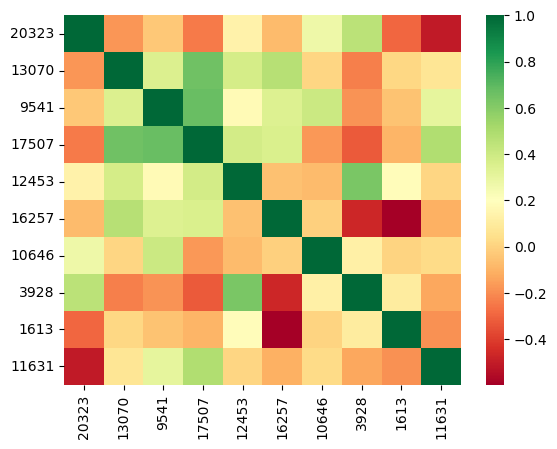

In [365]:
heatmap_sns = sns.heatmap(user_similarity_df.iloc[:,:10].head(10),cmap='RdYlGn')

### Closest Cosine Similarity Neighbors
Sorting and showing the users with the closest top 10 cosine similarity of each user. We can assume these are users that rate jokes similarily.

In [454]:
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[1:n+1].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [455]:
# top 10 neighbours for each user
top_10_user_similarity = find_n_neighbours(user_similarity_df,10)
top_10_user_similarity.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
20323,8802,2504,5045,22213,9955,2532,22551,5351,11268,775
13070,5603,10139,17703,19778,16442,23423,10677,16180,8750,10877
9541,23027,98,11666,21792,8233,15310,16917,17927,2682,20200
17507,15148,12785,6702,5575,22875,5817,14974,9109,20304,13409
12453,13355,16432,4705,5329,11890,2342,10016,14055,9556,794


## Column wise average for our closest group of neighbors
We grab the average ratings for the jokes, for just the users that are the cloest neighbors to our test user # 20323

In [456]:
def column_wise_average(df, selected_users):
    # Select rows by user IDs
    subset = df.loc[selected_users]
    
    # Compute column-wise mean
    return subset.mean()

In [457]:
train_data1, test_data1 = train_test_split(original_df, test_size=0.2, random_state=30)
test_data1 = test_data1.drop(columns=['Number of Jokes Rated'])
test_data1

,User,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
20323,20324,8.54,3.54,-6.41,-5.68,-7.28,4.76,1.31,1.84,3.93,...,NaN,3.40,7.72,9.37,0.29,3.98,7.18,1.41,-7.23,5.78
13070,13071,2.14,1.80,2.52,-1.65,-1.17,-1.26,-4.76,-3.30,2.86,...,NaN,NaN,1.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9541,9542,-8.69,-8.69,-0.24,-8.93,6.21,2.14,2.57,-9.32,-8.93,...,NaN,NaN,NaN,NaN,NaN,-4.95,NaN,NaN,NaN,NaN
17507,17508,3.11,-2.38,8.01,-5.19,4.17,4.76,-0.49,-7.77,-2.91,...,6.41,5.29,5.29,4.76,5.34,5.58,-4.32,5.24,-2.18,-6.02
12453,12454,-5.87,-8.20,5.34,8.83,-0.63,7.67,3.83,3.69,-0.10,...,7.48,8.50,7.18,3.50,3.59,3.30,-0.15,-1.17,-0.49,6.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21183,21184,NaN,NaN,NaN,NaN,-3.20,NaN,-0.44,4.61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3292,3293,-4.08,-9.66,-0.63,-5.87,-0.34,-5.44,-5.49,-3.98,-4.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11461,11462,NaN,NaN,NaN,NaN,0.10,-1.02,0.39,-3.25,NaN,...,-3.35,NaN,NaN,NaN,NaN,-3.40,NaN,NaN,NaN,NaN
20883,20884,8.35,-2.91,-9.71,-9.56,-2.91,4.56,0.73,2.28,1.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [458]:
df_2 = pd.melt(test_data1, id_vars=['User'])
df_2 = pd.DataFrame(df_2)
df_2 = df_2.rename(columns={"User": "user_id", "variable": "item_id", "value":"rating"})
df_2

,user_id,item_id,rating
0,20324,1,8.54
1,13071,1,2.14
2,9542,1,-8.69
3,17508,1,3.11
4,12454,1,-5.87
...,...,...,...
499695,21184,100,NaN
499696,3293,100,NaN
499697,11462,100,NaN
499698,20884,100,NaN


##### These are the average ratings for all 100 jokes for the 10 users closest to user # 20323

In [459]:
selected_users = top_10_user_similarity.iloc[0]
closest_user_average_ratings = column_wise_average(test_data1,selected_users)
closest_user_average_ratings = closest_user_average_ratings.iloc[1:]
closest_user_average_ratings

1      1.301667
2     -2.881667
3     -1.504000
4     -1.814000
5     -5.996000
         ...   
96     0.464000
97    -2.647500
98     0.000000
99     0.972500
100    1.650000
Length: 100, dtype: float64

In [460]:
closest_user_average_ratings_series = pd.Series(closest_user_average_ratings_series)

I have a df of closest cosine similarity neighbors. I want to get those users average scores from. average of those for the unrated. take df of closest neighbors and get their ratings, average for a jokes. 

In [461]:
df_filled = df_2[df_2['user_id'] == 20324].copy()

In [462]:
df_filled['newrating'] = df_filled['item_id'].map(closest_user_average_ratings)

In [463]:
df_filled

,user_id,item_id,rating,newrating
0,20324,1,8.54,1.301667
4997,20324,2,3.54,-2.881667
9994,20324,3,-6.41,-1.504000
14991,20324,4,-5.68,-1.814000
19988,20324,5,-7.28,-5.996000
...,...,...,...,...
474715,20324,96,3.98,0.464000
479712,20324,97,7.18,-2.647500
484709,20324,98,1.41,0.000000
489706,20324,99,-7.23,0.972500


Here are jokes that user 20324 had not rated. We gave them a predicted rating based on our 30 closest ratings our that user. User 20324 probably would like joke 89.

In [464]:
df_filled[(df_filled['user_id'] == 20324) & (df_filled['rating'].isna())]

,user_id,item_id,rating,newrating
349790,20324,71,NaN,-1.473333
354787,20324,72,NaN,-0.170000
359784,20324,73,NaN,1.700000
364781,20324,74,NaN,0.810000
374775,20324,76,NaN,3.885000
379772,20324,77,NaN,-2.283333
384769,20324,78,NaN,0.205000
389766,20324,79,NaN,-2.476667
394763,20324,80,NaN,0.244000
399760,20324,81,NaN,-4.297500


The RMSE (Root Mean Squared Error) measures the average difference between the observed values, and the predicted ones. For this case we are comparing our actual ratings from user 20324, compared the predicted average of the 30 closest cosine similarity raters to our that users ratings of the jokes in the dense group. Our RMSE being 4.6 suggests that our predicted ratings are on average within 4.6 rating points from the actual scores. Our model is pretty inaccurate.

In [465]:
RMSE = root_mean_squared_error(df_filled.rating[df_filled['rating'].notnull()],df_filled.newrating[df_filled['rating'].notnull()])
RMSE

4.609270239754419

### Possible Problems:
The biggest problem is if our closest users, also havent rated that joke. I had hoped that starting with the dense df would give us the most accurate similaritys. It seems possible that the way the users rated the dense group of jokes, is different than the way they would rate the rest of the jokes, we would be grouping users incorrectly then. 

## Part 2: Item-Item Collaborative Filtering

Item-based collaborative filtering (IBCF) uses item-to-item similarity based on user ratings to find items that are similar to the items the active user likes, we will use this to find similar jokes to ones that a user likes.

In [393]:
item_rec = original_df.drop(columns=['Number of Jokes Rated'])

In [394]:
item_rec = item_rec.set_index('User')

### Normalize
An important operation for rating matrices is to normalize the entries to, e.g., centering to remove rating bias by subtracting the row mean from all ratings in the row. Normalization is used to remove individual rating bias by users who consistently always use lower or higher ratings than other users. We also set the unrated jokes to 0 so we can perform similarities on them.

In [401]:
normalized_item_rec = item_rec.sub(item_rec.mean(axis=1), axis=0)
normalized_item_rec = normalized_item_rec.fillna(0)

We transpose the df to get the jokes as the index

In [409]:
normalized_item_rec = normalized_item_rec.T

In [410]:
normalized_item_rec

User,1,2,3,4,5,6,7,8,9,10,...,24974,24975,24976,24977,24978,24979,24980,24981,24982,24983
1,-8.721625,3.178375,0.000000,0.000000,7.598375,-7.071625,0.000000,5.938375,-4.691625,2.108375,...,0.898375,0.000000,0.000000,0.458375,0.000000,-0.461625,8.228375,0.000000,0.000000,1.528375
2,8.583391,-0.496609,0.000000,8.143391,4.403391,-3.746609,0.000000,2.953391,-3.746609,4.943391,...,-9.626609,-9.426609,7.993391,1.543391,0.000000,7.223391,-8.366609,0.000000,0.000000,2.463391
3,-9.975385,6.044615,0.000000,0.000000,-4.485385,0.124615,0.000000,8.854615,-9.735385,4.834615,...,-8.515385,0.000000,0.000000,2.064615,0.000000,8.764615,8.274615,0.000000,0.000000,-4.295385
4,-6.713487,5.816513,0.000000,0.000000,-3.943487,-7.053487,0.000000,-4.763487,-5.443487,4.456513,...,0.000000,0.000000,0.000000,3.286513,0.000000,3.776513,10.526513,0.000000,0.000000,5.716513
5,-7.921139,-2.781139,8.628861,1.398861,0.958861,-7.491139,8.188861,-8.561139,-9.141139,6.008861,...,-8.941139,5.568861,8.388861,4.258861,7.268861,2.798861,0.468861,-8.171139,-10.111139,-2.681139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.000000,-3.663802,0.000000,0.000000,0.026198,-4.873802,0.806198,-4.873802,-1.813802,0.000000,...,0.000000,0.000000,7.406198,-1.863802,0.000000,7.506198,-9.723802,0.000000,0.000000,0.000000
97,-7.298856,1.391144,0.000000,0.000000,1.441144,-1.618856,0.000000,0.471144,-1.958856,0.000000,...,0.000000,0.000000,0.000000,7.651144,0.000000,4.881144,-8.898856,0.000000,0.000000,0.000000
98,0.000000,-0.424536,0.000000,0.000000,5.785464,-9.844536,0.000000,-0.814536,-1.054536,0.000000,...,0.000000,0.000000,8.365464,8.405464,0.000000,7.925464,-9.354536,0.000000,0.000000,0.000000
99,0.000000,-4.287395,0.000000,0.000000,1.832605,-5.017395,0.000000,1.342605,-3.367395,0.000000,...,-3.707395,0.000000,0.000000,8.912605,0.000000,8.822605,9.162605,0.000000,0.000000,0.000000


### Cosine Similairty (Joke Rating Similarity):
The cosine of an angle is a function that decreases from 1 to -1 as the angle increases from 0 to 180. You can use the cosine of the angle to find the similarity between two users. The higher the angle, the lower will be the cosine and thus, the lower will be the similarity of the users. You can also inverse the value of the cosine of the angle to get the cosine distance between the users by subtracting it from 1. This should group jokes that are similar in rating.

In [419]:
joke_similarity = cosine_similarity(normalized_item_rec)

In [420]:
joke_similarity

array([[1.        , 0.36269036, 0.35614004, ..., 0.12581767, 0.1251231 ,
        0.14609155],
       [0.36269036, 1.        , 0.27931069, ..., 0.19306961, 0.10502736,
        0.20832425],
       [0.35614004, 0.27931069, 1.        , ..., 0.15580797, 0.1442891 ,
        0.2324058 ],
       ...,
       [0.12581767, 0.19306961, 0.15580797, ..., 1.        , 0.28362382,
        0.40954574],
       [0.1251231 , 0.10502736, 0.1442891 , ..., 0.28362382, 1.        ,
        0.287647  ],
       [0.14609155, 0.20832425, 0.2324058 , ..., 0.40954574, 0.287647  ,
        1.        ]])

##### This is cosine similarity between the 100 jokes:

In [421]:
joke_similarity_df = pd.DataFrame(joke_similarity)

#reset the index's back to the tes data user_ids rather than 0-4996 that cosine defaults to
joke_similarity_df.index = normalized_item_rec.index
joke_similarity_df.columns = normalized_item_rec.index

joke_similarity_df 

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,1.000000,0.362690,0.356140,0.284144,0.141452,0.184682,0.161738,0.153847,0.318997,0.304383,...,0.117984,0.102573,0.137465,0.160817,0.148895,0.142739,0.140995,0.125818,0.125123,0.146092
2,0.362690,1.000000,0.279311,0.300435,0.175442,0.208779,0.170889,0.104768,0.233495,0.255307,...,0.105521,0.099920,0.121203,0.098861,0.100820,0.105985,0.120094,0.193070,0.105027,0.208324
3,0.356140,0.279311,1.000000,0.362129,0.176821,0.244189,0.147014,0.149409,0.306989,0.278348,...,0.124190,0.124636,0.144655,0.129085,0.152242,0.122739,0.123745,0.155808,0.144289,0.232406
4,0.284144,0.300435,0.362129,1.000000,0.165173,0.284782,0.159111,0.074049,0.358951,0.230463,...,0.147791,0.195804,0.187727,0.160339,0.182468,0.186137,0.167439,0.262802,0.228524,0.302148
5,0.141452,0.175442,0.176821,0.165173,1.000000,0.171833,0.200219,0.161630,0.091734,0.147446,...,0.081577,0.072984,0.089255,0.072582,0.081793,0.067977,0.069648,0.138641,0.095656,0.170821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.142739,0.105985,0.122739,0.186137,0.067977,0.208857,0.087052,0.051866,0.248113,0.128344,...,0.311552,0.361497,0.350092,0.391696,0.398235,1.000000,0.418522,0.223271,0.366638,0.221916
97,0.140995,0.120094,0.123745,0.167439,0.069648,0.170656,0.113062,0.079377,0.206695,0.112472,...,0.293352,0.283874,0.328870,0.349606,0.318327,0.418522,1.000000,0.232303,0.348921,0.181949
98,0.125818,0.193070,0.155808,0.262802,0.138641,0.173184,0.099702,-0.003684,0.115984,0.084101,...,0.195641,0.232003,0.251530,0.161958,0.195323,0.223271,0.232303,1.000000,0.283624,0.409546
99,0.125123,0.105027,0.144289,0.228524,0.095656,0.193678,0.090010,0.064581,0.220191,0.124980,...,0.275241,0.311675,0.296950,0.324578,0.321561,0.366638,0.348921,0.283624,1.000000,0.287647


As an example, here are the similarly rated jokes to Joke 16:

In [589]:
joke_similarity_df.loc["10"].sort_values(ascending=False)

10    1.000000
38    0.361532
23    0.353488
22    0.346321
44    0.339317
        ...   
80    0.078767
83    0.076237
73    0.073737
71    0.071469
89    0.069534
Name: 10, Length: 100, dtype: float64

In [590]:
jokes_rating_copy = original_df.drop(columns=['Number of Jokes Rated',"User"]).copy().T
jokes_rating_copy

,0,1,2,3,4,5,6,7,8,9,...,24973,24974,24975,24976,24977,24978,24979,24980,24981,24982
1,-7.82,4.08,NaN,NaN,8.50,-6.17,NaN,6.84,-3.79,3.01,...,1.80,NaN,NaN,1.36,NaN,0.44,9.13,NaN,NaN,2.43
2,8.79,-0.29,NaN,8.35,4.61,-3.54,NaN,3.16,-3.54,5.15,...,-9.42,-9.22,8.20,1.75,NaN,7.43,-8.16,NaN,NaN,2.67
3,-9.66,6.36,NaN,NaN,-4.17,0.44,NaN,9.17,-9.42,5.15,...,-8.20,NaN,NaN,2.38,NaN,9.08,8.59,NaN,NaN,-3.98
4,-8.16,4.37,NaN,NaN,-5.39,-8.50,NaN,-6.21,-6.89,3.01,...,NaN,NaN,NaN,1.84,NaN,2.33,9.08,NaN,NaN,4.27
5,-7.52,-2.38,9.03,1.80,1.36,-7.09,8.59,-8.16,-8.74,6.41,...,-8.54,5.97,8.79,4.66,7.67,3.20,0.87,-7.77,-9.71,-2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,NaN,-2.14,NaN,NaN,1.55,-3.35,2.33,-3.35,-0.29,NaN,...,NaN,NaN,8.93,-0.34,NaN,9.03,-8.20,NaN,NaN,NaN
97,-5.63,3.06,NaN,NaN,3.11,0.05,NaN,2.14,-0.29,NaN,...,NaN,NaN,NaN,9.32,NaN,6.55,-7.23,NaN,NaN,NaN
98,NaN,0.34,NaN,NaN,6.55,-9.08,NaN,-0.05,-0.29,NaN,...,NaN,NaN,9.13,9.17,NaN,8.69,-8.59,NaN,NaN,NaN
99,NaN,-4.32,NaN,NaN,1.80,-5.05,NaN,1.31,-3.40,NaN,...,-3.74,NaN,NaN,8.88,NaN,8.79,9.13,NaN,NaN,NaN


We previously predicted with our user-user recommendatiom, that User 20324 probably would like joke 89.

In [632]:
joke_89 = jokes_rating_copy.loc[['89']]
joke_89 = joke_89.fillna(0)
joke_89

,0,1,2,3,4,5,6,7,8,9,...,24973,24974,24975,24976,24977,24978,24979,24980,24981,24982
89,0.0,4.56,0.0,0.0,2.82,-5.68,0.0,-0.24,4.56,0.0,...,0.0,0.0,0.0,0.0,0.0,9.13,-1.36,0.0,0.0,0.0


User 20323's joke ratings:

In [622]:
#training_data_y_jokes
user_20323 = jokes_rating_copy[20323]
user_20323

1      8.54
2      3.54
3     -6.41
4     -5.68
5     -7.28
       ... 
96     3.98
97     7.18
98     1.41
99    -7.23
100    5.78
Name: 20323, Length: 100, dtype: float64

Including just the users who rated the jokes our user did

In [623]:
#training_data_x_jokes
training_data_x_jokes = jokes_rating_copy[user_20323.notnull()]
training_data_x_jokes = training_data_x_jokes.fillna(0)
training_data_x_jokes

,0,1,2,3,4,5,6,7,8,9,...,24973,24974,24975,24976,24977,24978,24979,24980,24981,24982
1,-7.82,4.08,0.00,0.00,8.50,-6.17,0.00,6.84,-3.79,3.01,...,1.80,0.00,0.00,1.36,0.00,0.44,9.13,0.00,0.00,2.43
2,8.79,-0.29,0.00,8.35,4.61,-3.54,0.00,3.16,-3.54,5.15,...,-9.42,-9.22,8.20,1.75,0.00,7.43,-8.16,0.00,0.00,2.67
3,-9.66,6.36,0.00,0.00,-4.17,0.44,0.00,9.17,-9.42,5.15,...,-8.20,0.00,0.00,2.38,0.00,9.08,8.59,0.00,0.00,-3.98
4,-8.16,4.37,0.00,0.00,-5.39,-8.50,0.00,-6.21,-6.89,3.01,...,0.00,0.00,0.00,1.84,0.00,2.33,9.08,0.00,0.00,4.27
5,-7.52,-2.38,9.03,1.80,1.36,-7.09,8.59,-8.16,-8.74,6.41,...,-8.54,5.97,8.79,4.66,7.67,3.20,0.87,-7.77,-9.71,-2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.00,-2.14,0.00,0.00,1.55,-3.35,2.33,-3.35,-0.29,0.00,...,0.00,0.00,8.93,-0.34,0.00,9.03,-8.20,0.00,0.00,0.00
97,-5.63,3.06,0.00,0.00,3.11,0.05,0.00,2.14,-0.29,0.00,...,0.00,0.00,0.00,9.32,0.00,6.55,-7.23,0.00,0.00,0.00
98,0.00,0.34,0.00,0.00,6.55,-9.08,0.00,-0.05,-0.29,0.00,...,0.00,0.00,9.13,9.17,0.00,8.69,-8.59,0.00,0.00,0.00
99,0.00,-4.32,0.00,0.00,1.80,-5.05,0.00,1.31,-3.40,0.00,...,-3.74,0.00,0.00,8.88,0.00,8.79,9.13,0.00,0.00,0.00


Remove the user 20323 unrated jokes 

In [624]:
user_20323.dropna(inplace=True)
user_20323

1      8.54
2      3.54
3     -6.41
4     -5.68
5     -7.28
       ... 
96     3.98
97     7.18
98     1.41
99    -7.23
100    5.78
Name: 20323, Length: 81, dtype: float64

In [625]:
jokes_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)

In [626]:
jokes_knn.fit(training_data_x_jokes,user_20323)

KNeighborsRegressor(metric='cosine', n_neighbors=10)

In [633]:
prediction = jokes_knn.predict(joke_89)

Predicted our user 20323 would rate joke 89 as 4.311

In [634]:
prediction[0]

np.float64(4.311)